In [36]:
import numpy as np
import os
from matplotlib import pyplot as plt
from filters.filters import IEKF, Madgwick, ParticleFilter
from tools.objects import Gaussian
from tools import compare, data_processing, transform, utils
from tools.tools_ahrs import plot
import mrob
from collections import defaultdict

In [18]:
DATA = "tum" # 'tum' or 'record'
DOWNSCALE = 1

errors = {}

# Load Data

In [19]:
if DATA == 'tum':
    x3_path = os.path.join("../data", "TUM-VI", "imu0")
    mocap_path = os.path.join("../data", "TUM-VI", "mocap0")
    take_name = "outdoors1.csv"

    t_base, data_gyr, data_acc = data_processing.import_tum_imu(os.path.join(x3_path, take_name), smoothing=False)
    t_base, data_gyr, data_acc = data_processing.downsample(DOWNSCALE, t_base, data_gyr, data_acc)

    freq_tum = 120/DOWNSCALE # Hz

    data_mocap_t, data_mocap_q, data_mocap_T = data_processing.import_tum_mocap(os.path.join(mocap_path, take_name), smoothing=False)
    data_mocap_t, data_mocap_q, data_mocap_T = data_processing.downsample(DOWNSCALE, data_mocap_t, data_mocap_q, data_mocap_T)

    t_base, data_gyr, data_acc, data_acc, data_mocap_q = data_processing.sync_mocap_and_data(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

else:
    x3_path_my = os.path.join("../data", "X3_simple", "Random_walk_2025-03-06_19-02-36.207_TGW")
    # x3_path = "madgwick_filter/recordings/X3_simple/Standing_still_2025-03-06_18-50-19.416_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Basic_motions_2025-03-06_18-45-09.848_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Walking_2025-03-06_18-37-32.144_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Walking_talking_2025-03-06_18-41-53.764_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Random_walk_2025-03-06_19-02-36.207_TGW"

    mocap_path_my = os.path.join("../data", "Mocap_simple", "Random_walk_Take 2025-03-06 06.38.58 PM_004.csv")
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Standing_still_Take 2025-03-06 06.38.58 PM_003.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Basic_motions_Take 2025-03-06 06.38.58 PM_002.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_Take 2025-03-06 06.38.58 PM.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_talking_Take 2025-03-06 06.38.58 PM_001.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Random_walk_Take 2025-03-06 06.38.58 PM_004.csv"

    freq_record = 100 # Hz

    t_base, data_gyr, data_acc, data_magn = data_processing.import_combined_data(os.path.join(x3_path_my, "combined_imu_data_7.csv"))
    t_base = t_base/1000
    data_mocap_t, data_mocap_q = data_processing.import_gamerotvec_data(os.path.join(x3_path_my, "game_rotation_vector_12.csv"))
    data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc= data_processing.trim_to_min_length(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

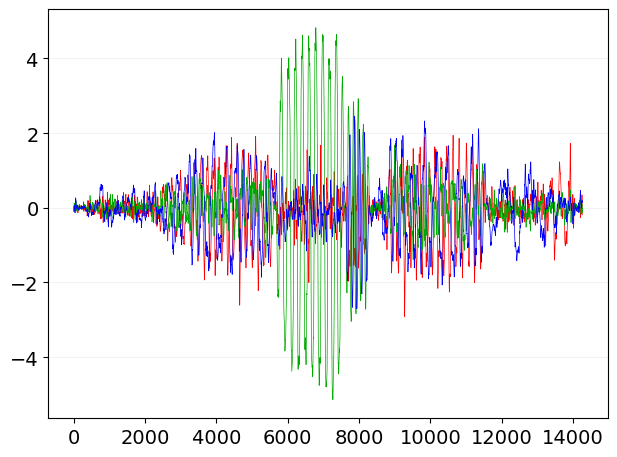

In [20]:
plot(data_gyr)

# Apply filter

## IEKF

In [21]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-4 * np.eye(3, 3)                                 # rad/s         ~(0.00122 ** 2) from sensors.csv
Q = 1e-3 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2    ~(0.00239 ** 2) from sensors.csv
# worse results with covs from sensors or from np.cov
#M = np.diag(np.diag(action_cov))
#Q = np.diag(np.diag(measurement_cov))
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
iekf = IEKF(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

for i in range(N):
    iekf.predict(u[i], dts[i])
    Ks[i], IVs[i] = iekf.update(data_acc[i])
    #iekf.update_fake()
    preds[i, :] = iekf.mu_bar
    s_preds[i] = iekf.Sigma_bar
    ups[i] = iekf.mu
    s_ups[i] = iekf.Sigma

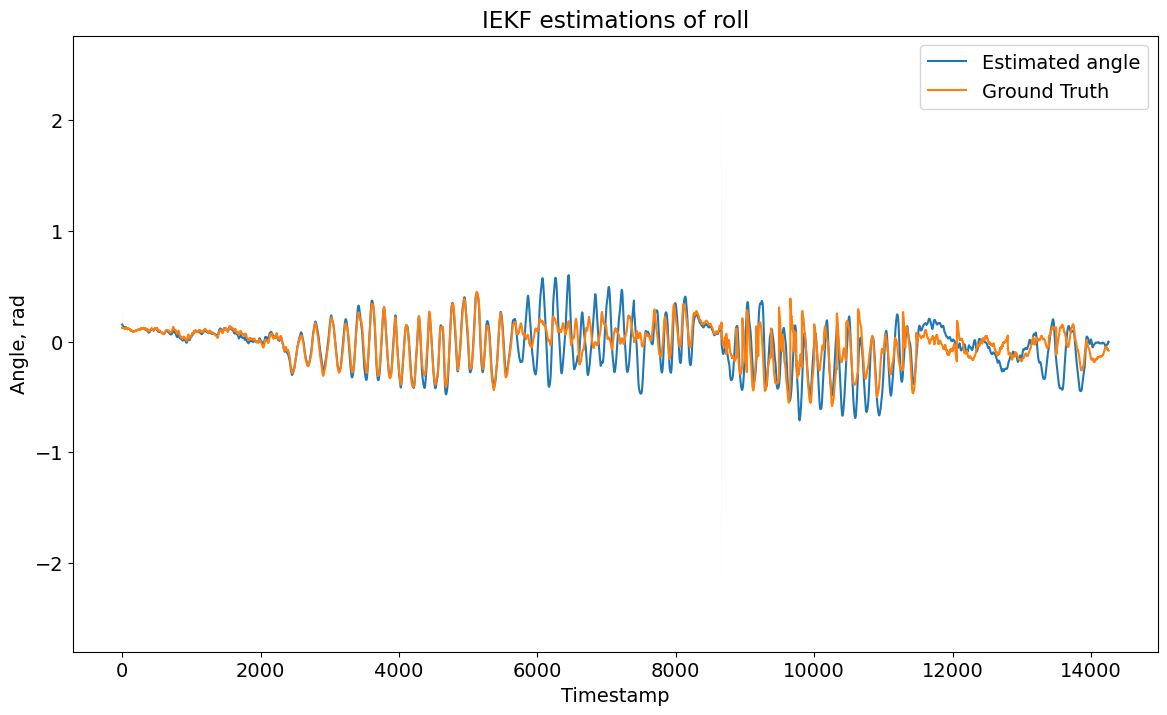

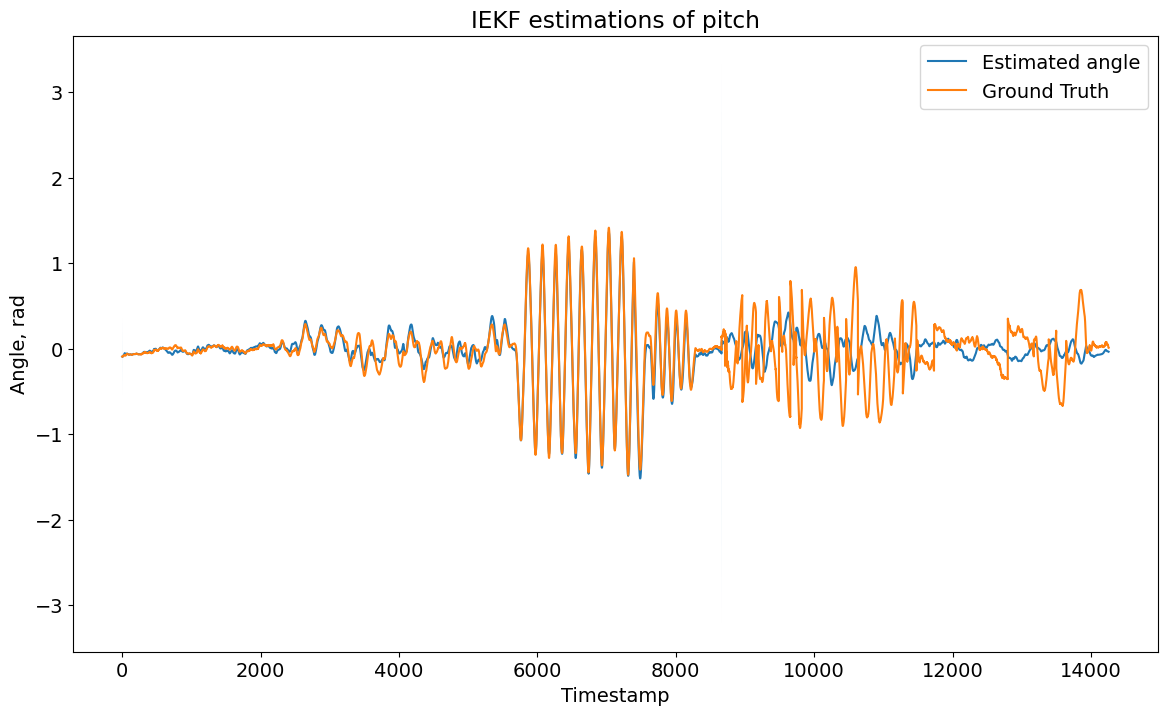

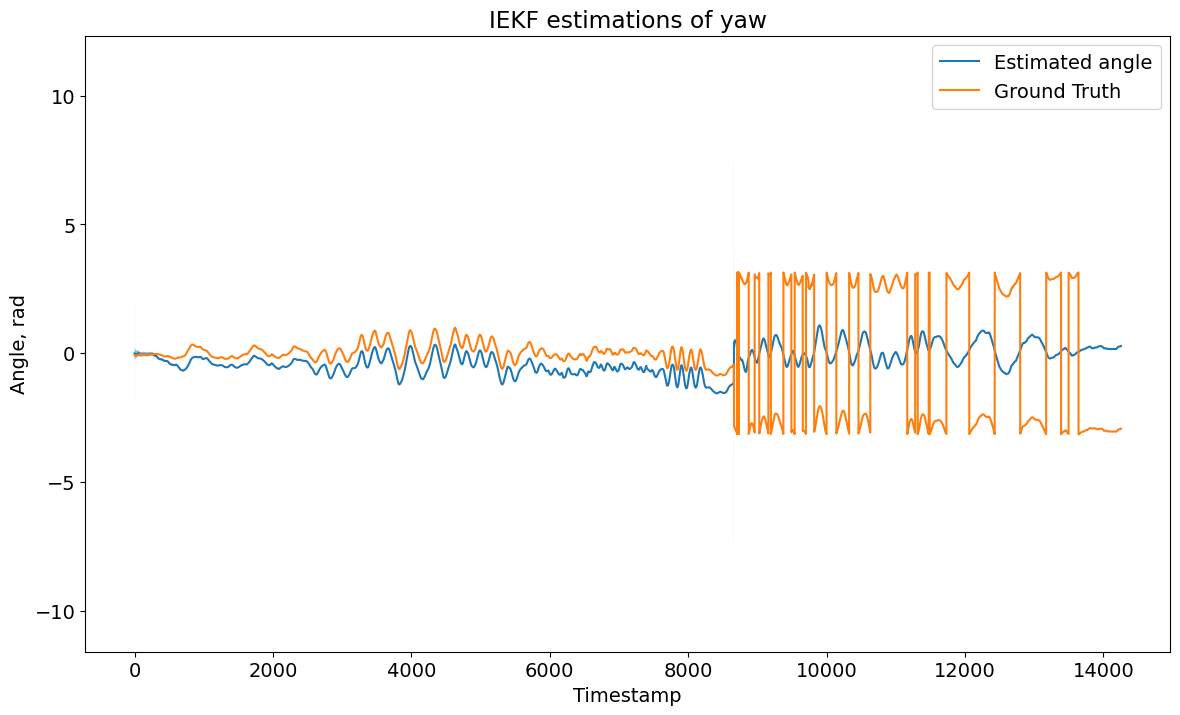

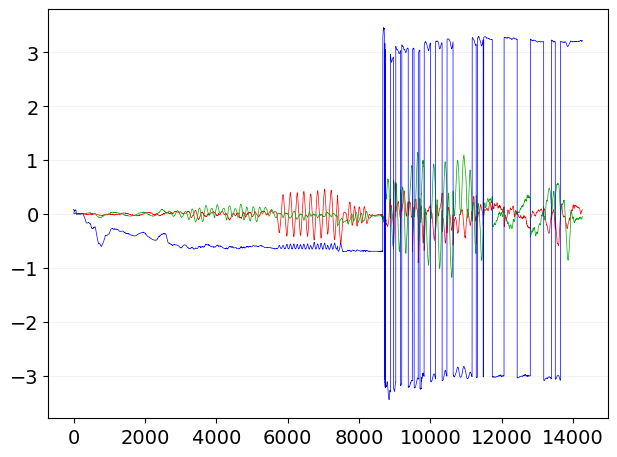

In [22]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

Mean distance between smartphone and mocap RPY attitude estimations:
[0.10339858 0.1570343  1.54806329]
STD of distance between smartphone and mocap RPY attitude estimations:
[0.16117913 0.27350979 1.99316718]
Distance between smartphone and mocap RPY attitude estimations:


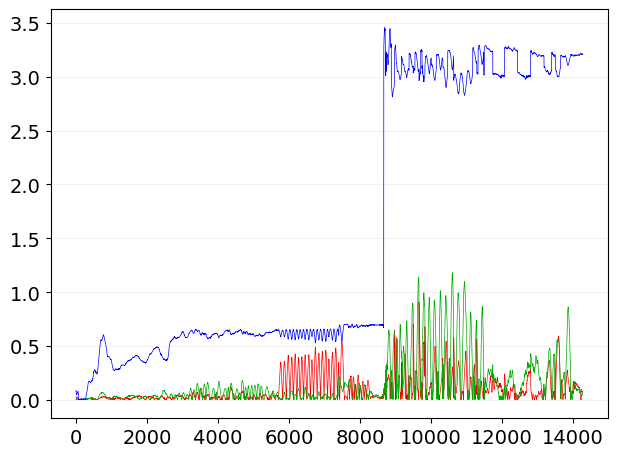

Last distance between smartphone and mocap RPY attitude estimations:
[0.08103224 0.04545753 3.20982695]
RMSE of APE between smartphone and mocap RPY attitude estimations:
[0.16252303 0.27398309 2.00132873]


Mean distance between smartphone and mocap RPY vector g estimations:
[0.01936411 0.02655647 0.00508398]
STD of distance between smartphone and mocap RPY vector g estimations:
[0.02686483 0.03704096 0.00832233]
Distance between smartphone and mocap RPY vector g estimations:


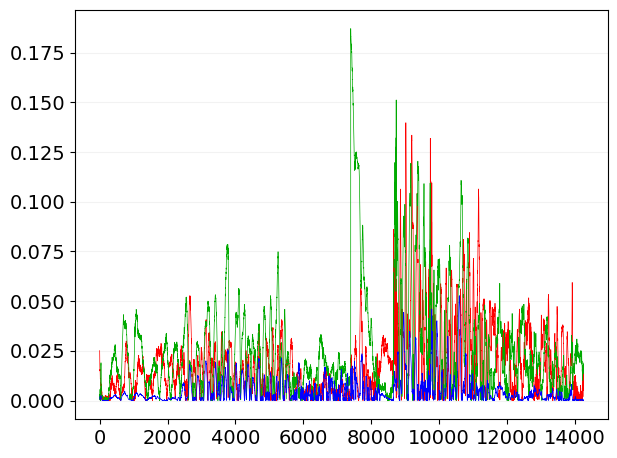

Last distance between smartphone and mocap RPY vector g estimations:
[5.20594456e-03 1.89154157e-02 6.20479018e-05]
RMSE of APE between smartphone and mocap RPY vector g estimations:
[0.02687562 0.03742038 0.00836054]


Mean Relative Pose Error
Mean distance between smartphone and mocap RPY attitude estimations:
[3.88497345 9.67873513 5.3948822 ]
STD of distance between smartphone and mocap RPY attitude estimations:
[ 39.4260571  155.34921171  95.88701473]
Relative Pose Error RPY


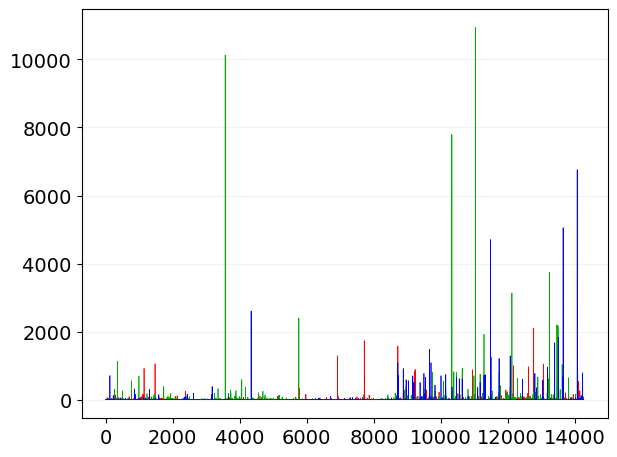

Last RPE between smartphone and mocap RPY attitude estimations:
[2.47947751 0.66360949 2.80942573]
RMSE of RPE between smartphone and mocap RPY attitude estimations:
[ 39.44033638 155.37119543  95.88722176]


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap RPY vector g estimations:
[5.32262733 4.15613969 5.59463321]
STD of distance between smartphone and mocap RPY vector g estimations:
[173.21060723  70.51200764 154.38122119]
Relative Pose Error RPY of vector g


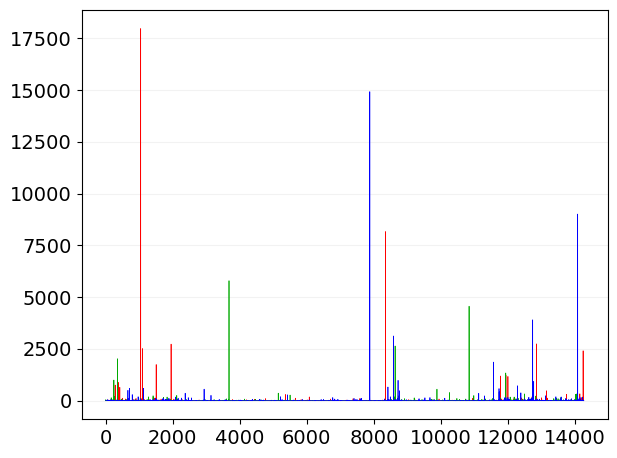

Last RPE between smartphone and mocap RPY vector g estimations:
[0.17111855 4.57064168 0.29834738]
RMSE of RPE between smartphone and mocap RPY vector g estimations:
[173.21038281  70.53137097 154.38084428]




In [23]:
(errors["iekf_rpy_ape_mean"], errors["iekf_rpy_ape_std"], errors["iekf_rpy_ape_rmse"],
errors["iekf_rpy_ape_g_mean"], errors["iekf_rpy_ape_g_std"], errors["iekf_rpy_ape_g_rmse"],
errors["iekf_rpy_rpe_mean"], errors["iekf_rpy_rpe_std"], errors["iekf_rpy_rpe_rmse"],
errors["iekf_rpy_rpe_g_mean"], errors["iekf_rpy_rpe_g_std"], errors["iekf_rpy_rpe_g_rmse"]) = compare.errors_estimation_rpy(gt, ups)

In [24]:
print(errors["iekf_rpy_ape_mean"])
print(errors["iekf_rpy_ape_std"])
print(errors["iekf_rpy_ape_rmse"])

[0.10339858 0.1570343  1.54806329]
[0.16117913 0.27350979 1.99316718]
[0.16252303 0.27398309 2.00132873]


Mean distance between smartphone and mocap attitude estimations:
1.5293345238123401
STD of distance between smartphone and mocap attitude estimations:
1.228524116134872
Distance between smartphone and mocap attitude estimations:


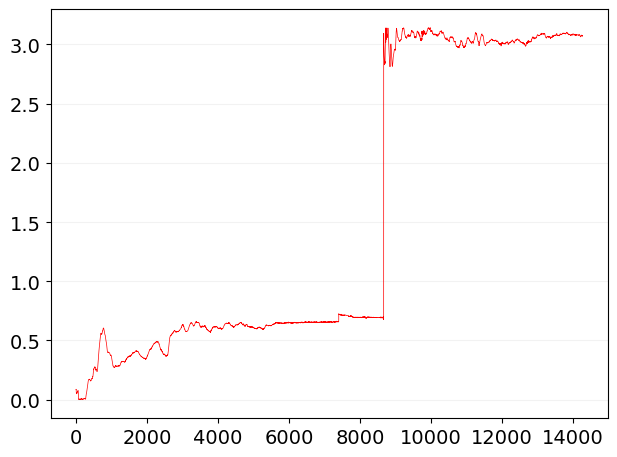

Last distance between smartphone and mocap attitude estimations:
3.0722095129389557
RMSE of APE between smartphone and mocap attitude estimations:
1.9616395490599305


G vectors in smartphone and (mocap-observed-smartphone) reference frames


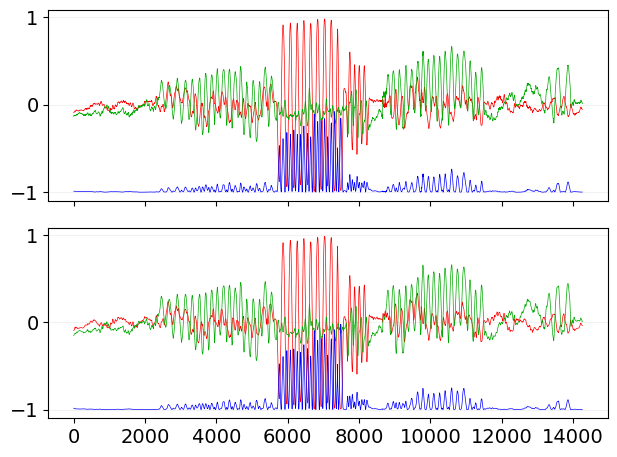

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


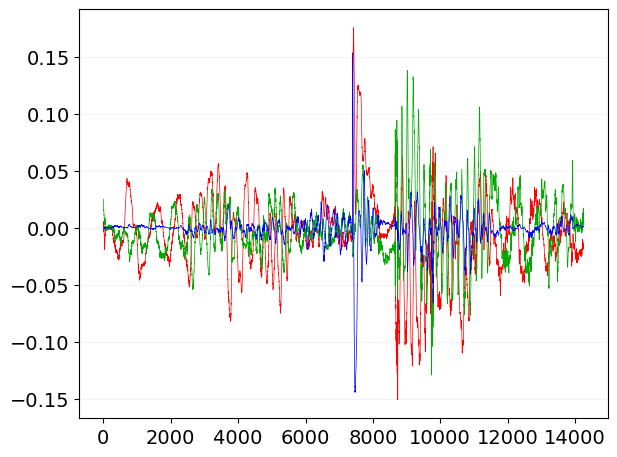

Mean distance between smartphone and mocap vector g estimations:
0.037238130718091844
STD of distance between smartphone and mocap vector g estimations:
0.02838768582867939
Distance between smartphone and mocap vector g estimations:


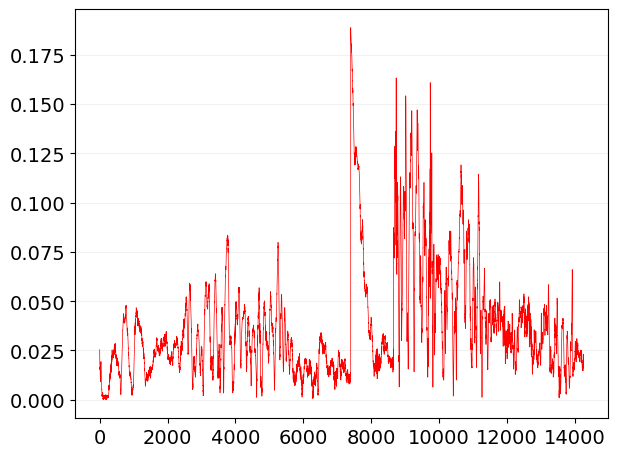

Last distance between smartphone and mocap vector g estimations:
0.019618834276804435
RMSE of APE between smartphone and mocap vector g estimations:
0.0468239528260713


Mean Relative Pose Error
Mean distance between smartphone and mocap attitude estimations:
0.0026568991364230993
STD of distance between smartphone and mocap attitude estimations:
0.020657043823287983
Relative Pose Error


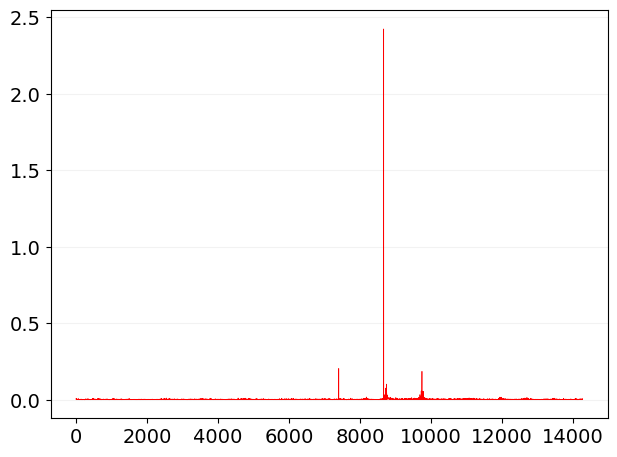

Last RPE between smartphone and mocap attitude estimations:
0.0046352435132367776
RMSE of RPE between smartphone and mocap attitude estimations:
0.020826488860041983


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap vector g estimations:
0.007964835209119166
STD of distance between smartphone and mocap vector g estimations:
0.02318269539363005
Relative Pose Error of vector g


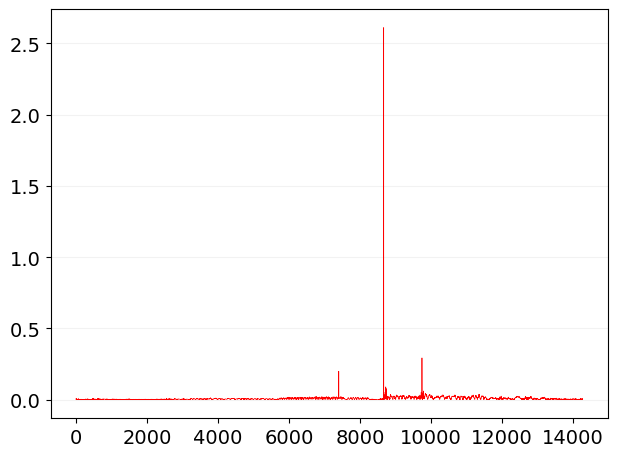

Last RPE between smartphone and mocap vector g estimations:
0.007087456165419162
RMSE of RPE between smartphone and mocap vector g estimations:
0.024512002446721092




In [25]:
q1 = transform.rpy_to_quats(gt)
q2 = transform.rpy_to_quats(ups)

(errors["iekf_quat_ape_mean"], errors["iekf_quat_ape_std"], errors["iekf_quat_ape_rmse"],
errors["iekf_quat_ape_g_mean"], errors["iekf_quat_ape_g_std"], errors["iekf_quat_ape_g_rmse"],
errors["iekf_quat_rpe_mean"], errors["iekf_quat_rpe_std"], errors["iekf_quat_rpe_rmse"],
errors["iekf_quat_rpe_g_mean"], errors["iekf_quat_rpe_g_std"], errors["iekf_quat_rpe_g_rmse"]) = compare.errors_estimation(q1, q2)

In [26]:
errors["iekf_quat_ape_mean"]
errors["iekf_quat_ape_std"]
errors["iekf_quat_ape_rmse"]

1.9616395490599305

## Particle Filter (PF)

In [56]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-4 * np.eye(3, 3)                                 # rad/s         ~(0.00122 ** 2) from sensors.csv
Q = 1e-3 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2    ~(0.00239 ** 2) from sensors.csv
# worse results with covs from sensors or from np.cov
#M = np.diag(np.diag(action_cov))
#Q = np.diag(np.diag(measurement_cov))
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
pf = ParticleFilter(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

for i in range(N):
    pf.predict(u[i], dts[i])
    pf.update(data_acc[i])
    preds[i, :] = pf.mu_bar
    s_preds[i] = pf.Sigma_bar
    ups[i] = pf.mu
    s_ups[i] = pf.Sigma

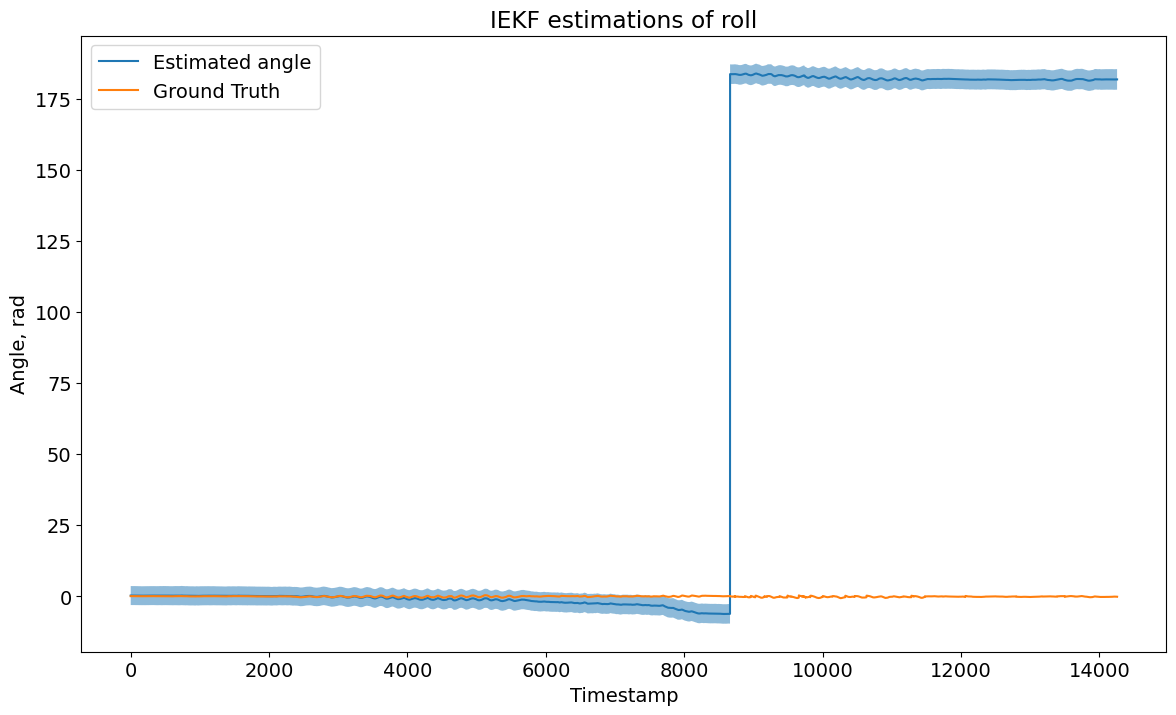

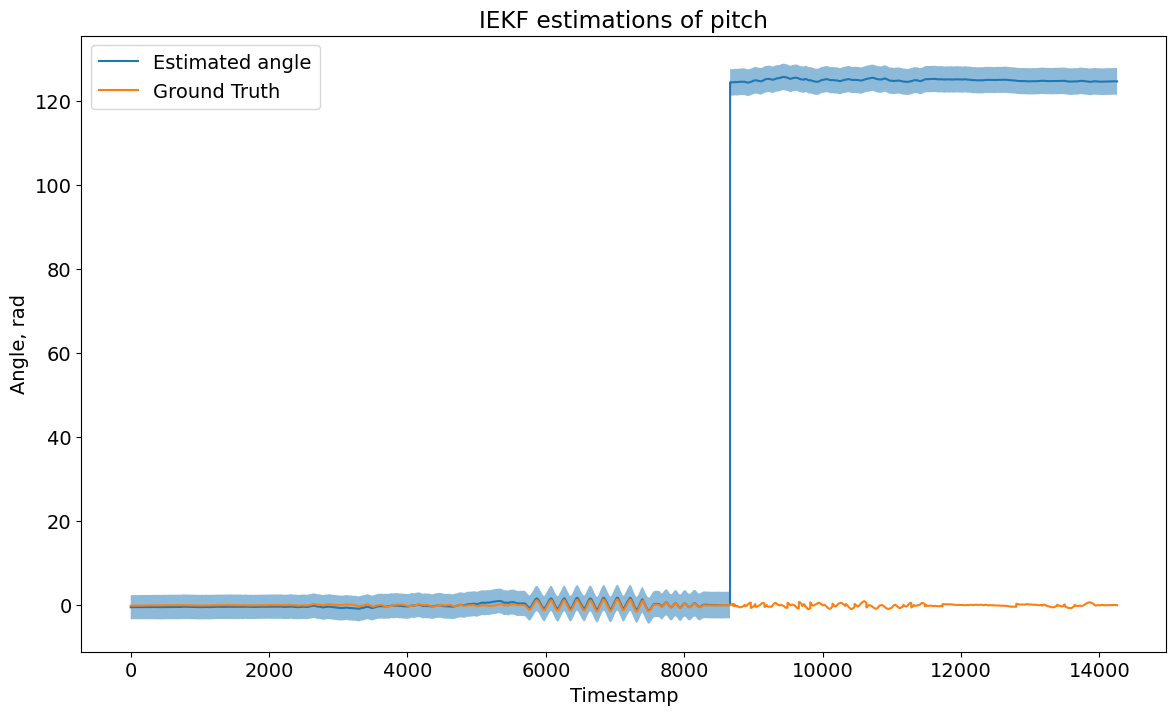

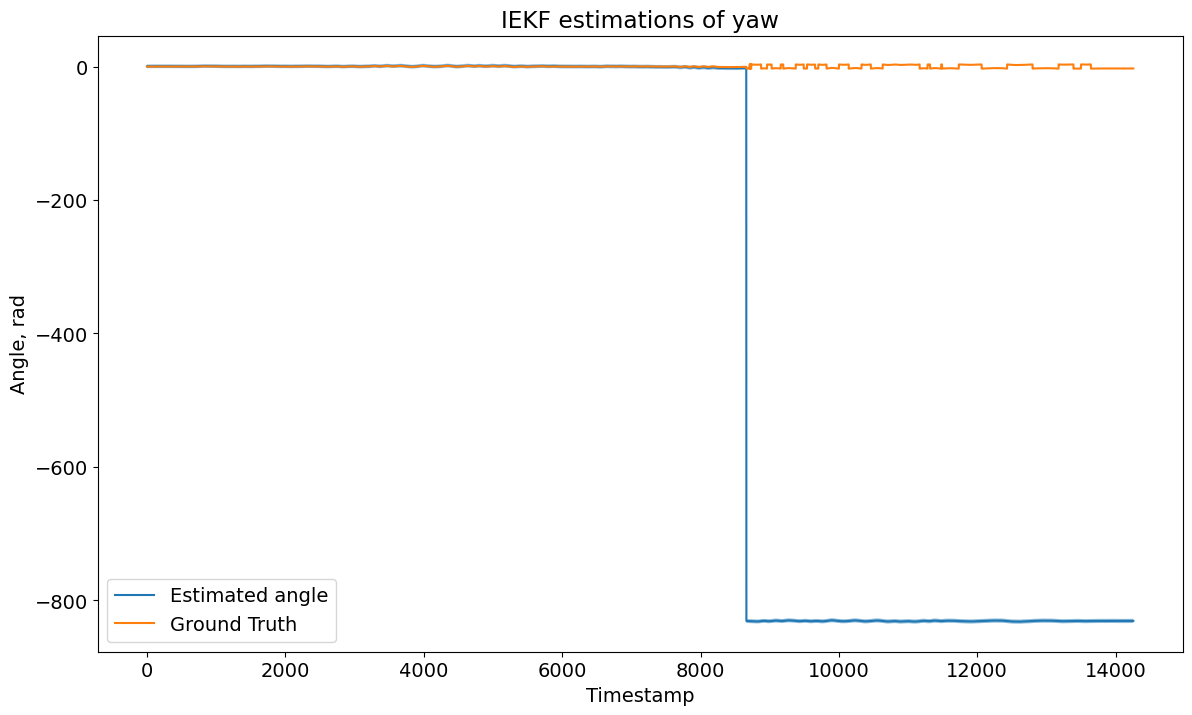

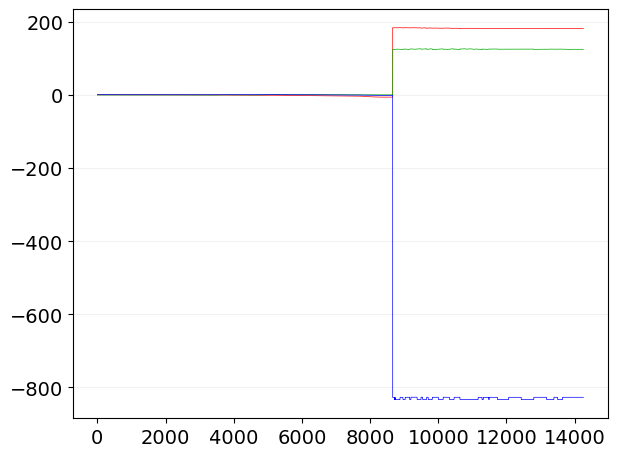

In [57]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

Mean distance between smartphone and mocap RPY attitude estimations:
[ 72.39590169  49.25987051 326.17650258]
STD of distance between smartphone and mocap RPY attitude estimations:
[ 89.65883419  61.06381885 405.59966471]
Distance between smartphone and mocap RPY attitude estimations:


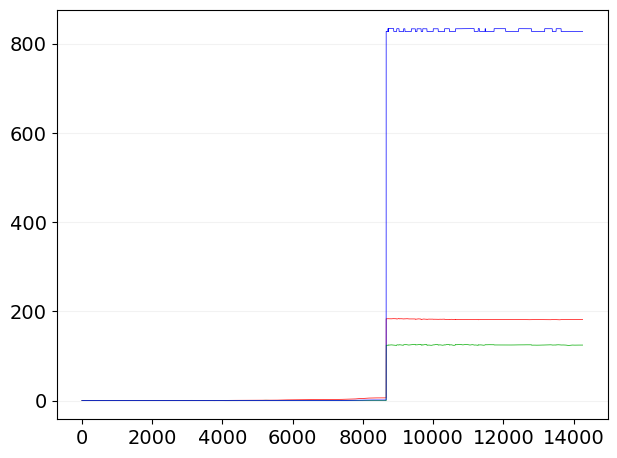

Last distance between smartphone and mocap RPY attitude estimations:
[181.85690444 124.68595577 827.70496897]
RMSE of APE between smartphone and mocap RPY attitude estimations:
[114.16047921  78.30805916 520.25192729]


Mean distance between smartphone and mocap RPY vector g estimations:
[0.40594874 0.43823537 0.13782797]
STD of distance between smartphone and mocap RPY vector g estimations:
[0.57899859 0.68883253 0.29040068]
Distance between smartphone and mocap RPY vector g estimations:


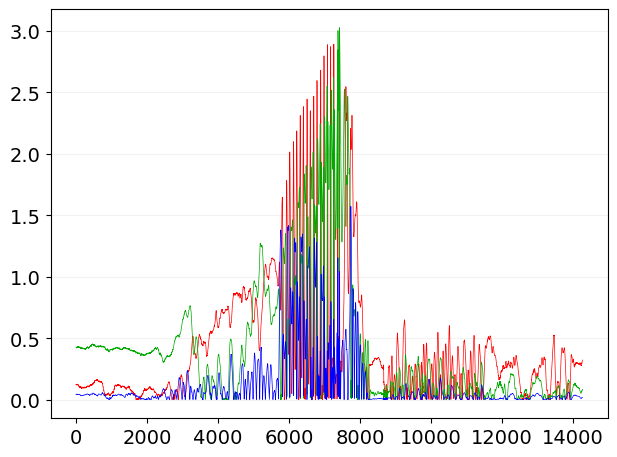

Last distance between smartphone and mocap RPY vector g estimations:
[0.32210223 0.08339005 0.01876663]
RMSE of APE between smartphone and mocap RPY vector g estimations:
[0.61509822 0.69045523 0.29445314]


Mean Relative Pose Error
Mean distance between smartphone and mocap RPY attitude estimations:
[ 4.98884382 17.38163618 47.33503485]
STD of distance between smartphone and mocap RPY attitude estimations:
[  76.51882404  552.23803565 4578.70447267]
Relative Pose Error RPY


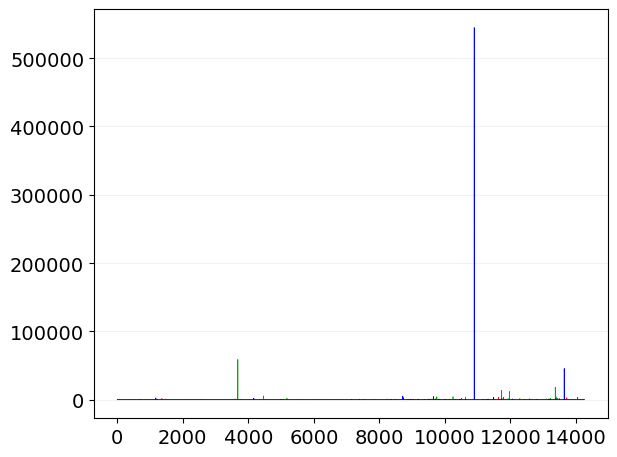

Last RPE between smartphone and mocap RPY attitude estimations:
[4.03869893 0.0876339  2.30485013]
RMSE of RPE between smartphone and mocap RPY attitude estimations:
[  76.51705335  552.22103469 4578.7190402 ]


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap RPY vector g estimations:
[  13.08958182   55.96864052 5671.03971733]
STD of distance between smartphone and mocap RPY vector g estimations:
[1.85615994e+02 1.96423913e+03 4.30095291e+05]
Relative Pose Error RPY of vector g


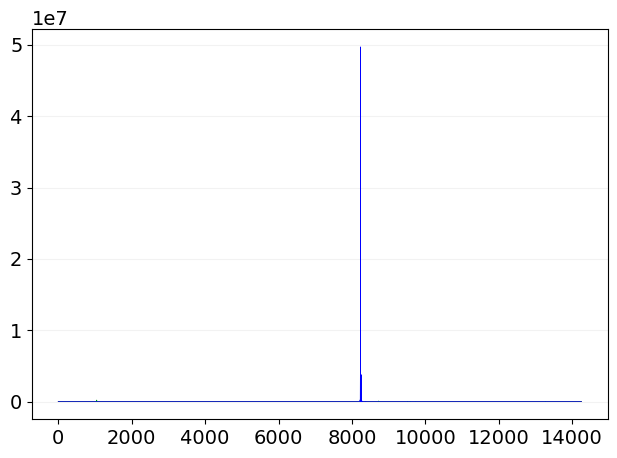

Last RPE between smartphone and mocap RPY vector g estimations:
[0.80855587 9.05761645 0.18982566]
RMSE of RPE between smartphone and mocap RPY vector g estimations:
[1.85612137e+02 1.96421869e+03 4.30092580e+05]




In [58]:
(errors["pf_rpy_ape_mean"], errors["pf_rpy_ape_std"], errors["pf_rpy_ape_rmse"],
errors["pf_rpy_ape_g_mean"], errors["pf_rpy_ape_g_std"], errors["pf_rpy_ape_g_rmse"],
errors["pf_rpy_rpe_mean"], errors["pf_rpy_rpe_std"], errors["pf_rpy_rpe_rmse"],
errors["pf_rpy_rpe_g_mean"], errors["pf_rpy_rpe_g_std"], errors["pf_rpy_rpe_g_rmse"]) = compare.errors_estimation_rpy(gt, ups)

Mean distance between smartphone and mocap attitude estimations:
1.5432958626112796
STD of distance between smartphone and mocap attitude estimations:
0.7554161878813267
Distance between smartphone and mocap attitude estimations:


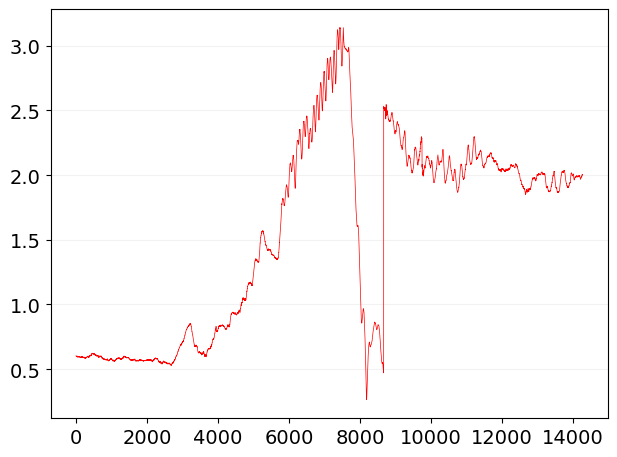

Last distance between smartphone and mocap attitude estimations:
2.0034941528935337
RMSE of APE between smartphone and mocap attitude estimations:
1.7182478597259239


G vectors in smartphone and (mocap-observed-smartphone) reference frames


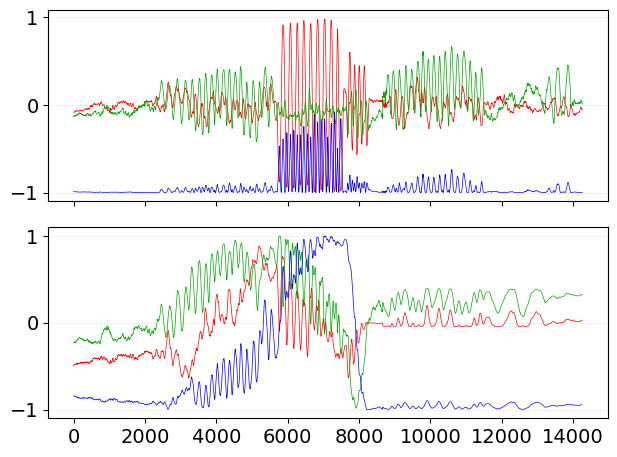

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


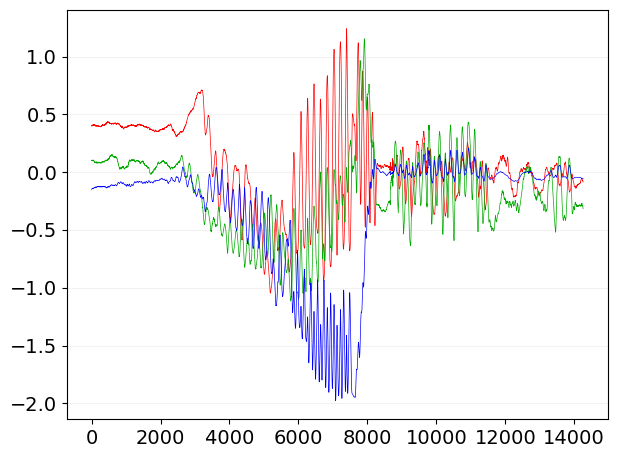

Mean distance between smartphone and mocap vector g estimations:
0.7098377391224969
STD of distance between smartphone and mocap vector g estimations:
0.6617688388735432
Distance between smartphone and mocap vector g estimations:


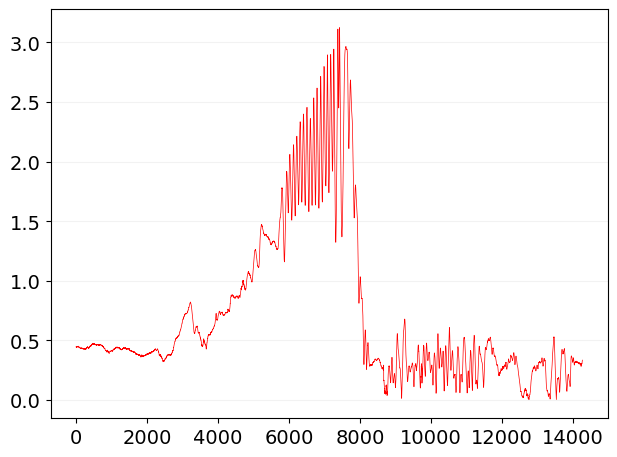

Last distance between smartphone and mocap vector g estimations:
0.3332505569760081
RMSE of APE between smartphone and mocap vector g estimations:
0.9704519011420253


Mean Relative Pose Error
Mean distance between smartphone and mocap attitude estimations:
0.009217647424371762
STD of distance between smartphone and mocap attitude estimations:
0.026863053969353137
Relative Pose Error


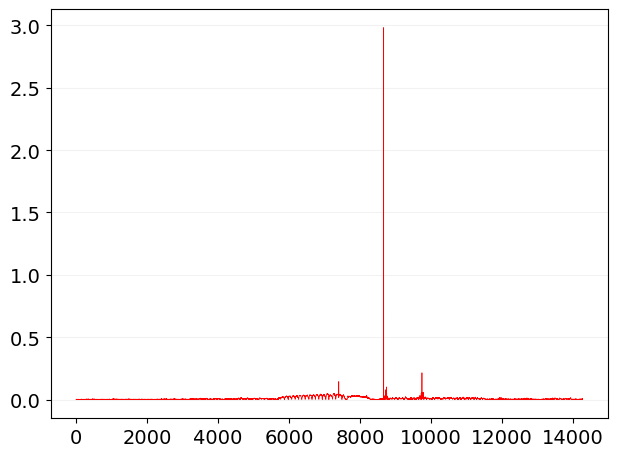

Last RPE between smartphone and mocap attitude estimations:
0.0038101434479135042
RMSE of RPE between smartphone and mocap attitude estimations:
0.028399613907679144


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap vector g estimations:
0.010269948020552151
STD of distance between smartphone and mocap vector g estimations:
0.01693480384721131
Relative Pose Error of vector g


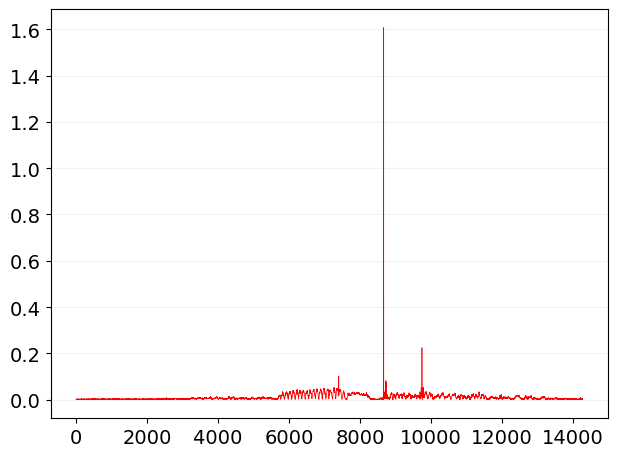

Last RPE between smartphone and mocap vector g estimations:
0.006289676130452209
RMSE of RPE between smartphone and mocap vector g estimations:
0.019805032070237698




In [59]:
q1 = transform.rpy_to_quats(gt)
q2 = transform.rpy_to_quats(ups)

(errors["pf_rpy_ape_mean"], errors["pf_rpy_ape_std"], errors["pf_rpy_ape_rmse"],
errors["pf_rpy_ape_g_mean"], errors["pf_rpy_ape_g_std"], errors["pf_rpy_ape_g_rmse"],
errors["pf_rpy_rpe_mean"], errors["pf_rpy_rpe_std"], errors["pf_rpy_rpe_rmse"],
errors["pf_rpy_rpe_g_mean"], errors["pf_rpy_rpe_g_std"], errors["pf_rpy_rpe_g_rmse"]) = compare.errors_estimation(q1, q2)

## Madgwick

In [31]:
# i_start = 0
# t_base, data_gyr, data_acc, data_mocap_t, data_mocap_q = data_processing.arrays_from_i(i_start, t_base, data_gyr, data_acc, data_mocap_t, data_mocap_q)

madgwick_filter = Madgwick()
madgwick_result = madgwick_filter.apply(data_gyr=data_gyr,
                      data_acc=data_acc,
                      freq=freq_tum if DATA=="tum" else freq_record)


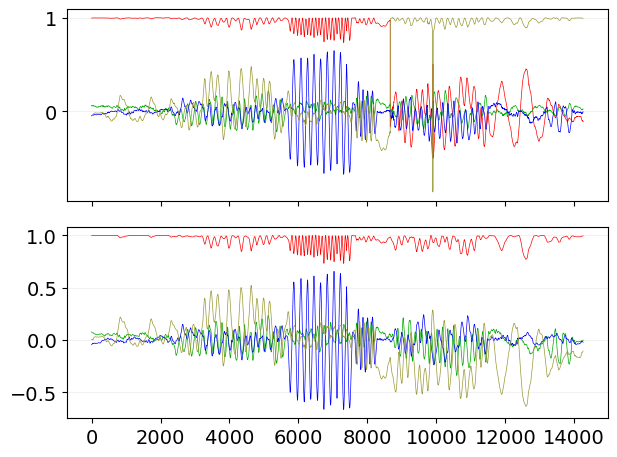

In [32]:
plot(data_mocap_q, madgwick_result.Q)

Mean distance between sensors and mocap attitude estimations:
1.1091480688282238
STD of distance between sensors and mocap attitude estimations:
1.247305933110516
Distance between sensors and mocap attitude estimations:


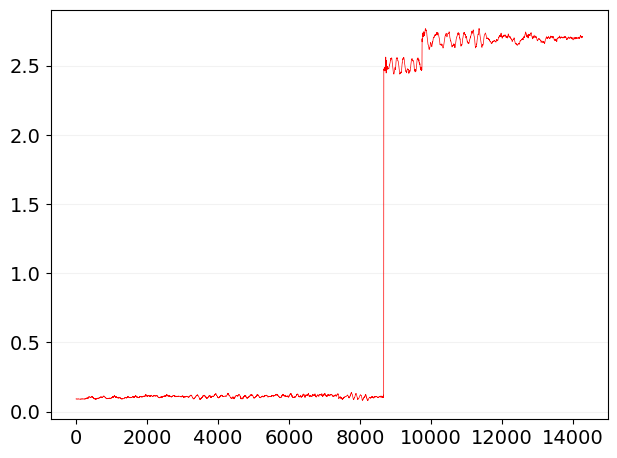

Last distance between sensors and mocap attitude estimations:
2.709050641193345
RMSE of APE between sensors and mocap attitude estimations:
1.6690932862842505


G vectors in smartphone and (mocap-observed-smartphone) reference frames


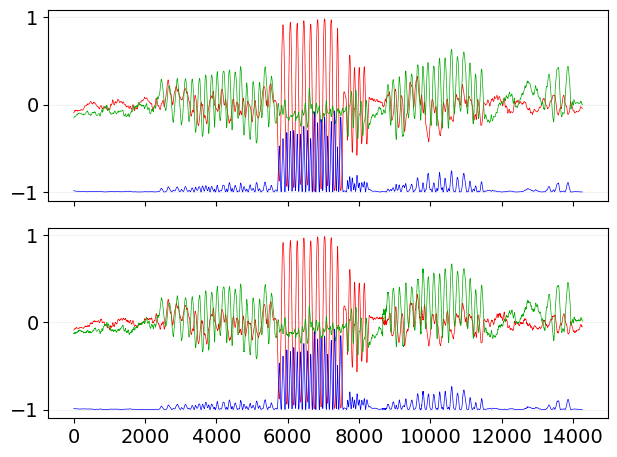

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


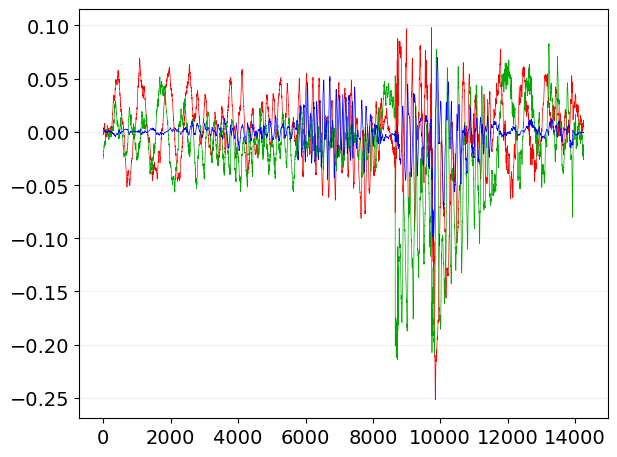

Mean distance between sensors and mocap vector g estimations:
0.04890385504217817
STD of distance between sensors and mocap vector g estimations:
0.041547967928648386
Distance between sensors and mocap vector g estimations:


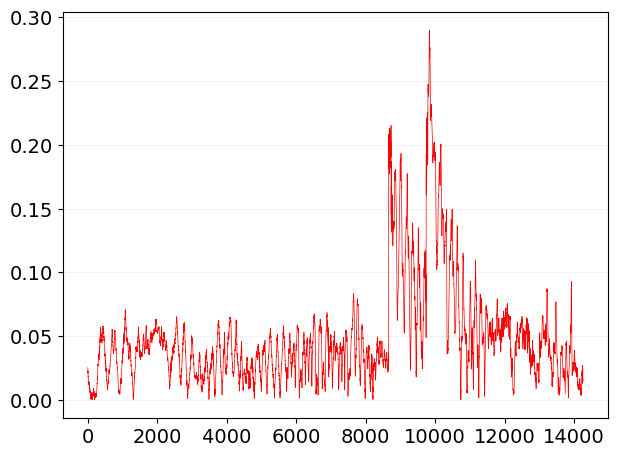

Last distance between sensors and mocap vector g estimations:
0.016734881957630565
RMSE of APE between sensors and mocap vector g estimations:
0.06416930410070026


Mean Relative Pose Error
Mean distance between sensors and mocap attitude estimations:
0.0026880924417294456
STD of distance between sensors and mocap attitude estimations:
0.0199846697598829
Relative Pose Error


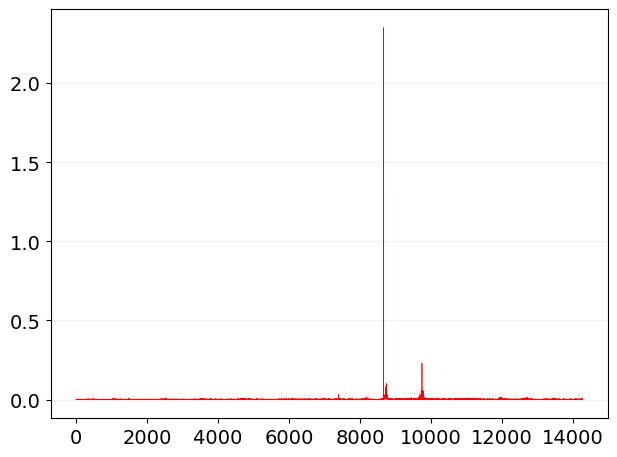

Last RPE between sensors and mocap attitude estimations:
0.005325319888336878
RMSE of RPE between sensors and mocap attitude estimations:
0.020163949242591954


Mean Relative Pose Error of vector g
Mean distance between sensors and mocap vector g estimations:
0.0057696060502503985
STD of distance between sensors and mocap vector g estimations:
0.017120500571498255
Relative Pose Error of vector g


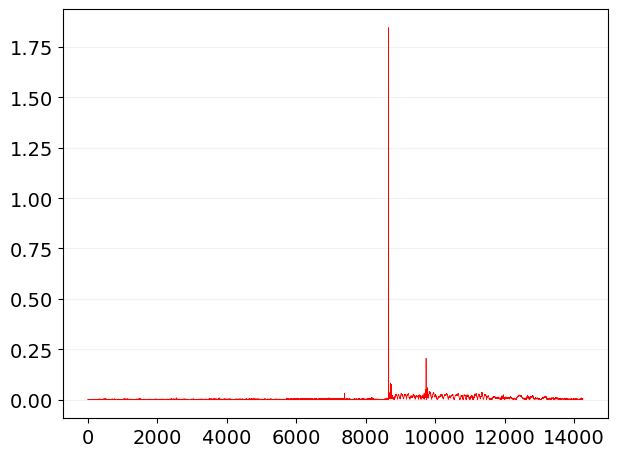

Last RPE between sensors and mocap vector g estimations:
0.0053252896079745956
RMSE of RPE between sensors and mocap vector g estimations:
0.018065971653294384




In [33]:
(errors["madgwick_quat_ape_mean"], errors["madgwick_quat_ape_std"], errors["madgwick_quat_ape_rmse"],
errors["madgwick_quat_ape_g_mean"], errors["madgwick_quat_ape_g_std"], errors["madgwick_quat_ape_g_rmse"],
errors["madgwick_quat_rpe_mean"], errors["madgwick_quat_rpe_std"], errors["madgwick_quat_rpe_rmse"],
errors["madgwick_quat_rpe_g_mean"], errors["madgwick_quat_rpe_g_std"], errors["madgwick_quat_rpe_g_rmse"]) = compare.errors_estimation(madgwick_result.Q, data_mocap_q, source1="sensors")

Mean distance between sensors and mocap RPY attitude estimations:
[0.06871674 0.14684774 1.26419552]
STD of distance between sensors and mocap RPY attitude estimations:
[0.11700723 0.27882995 1.94736534]
Distance between sensors and mocap RPY attitude estimations:


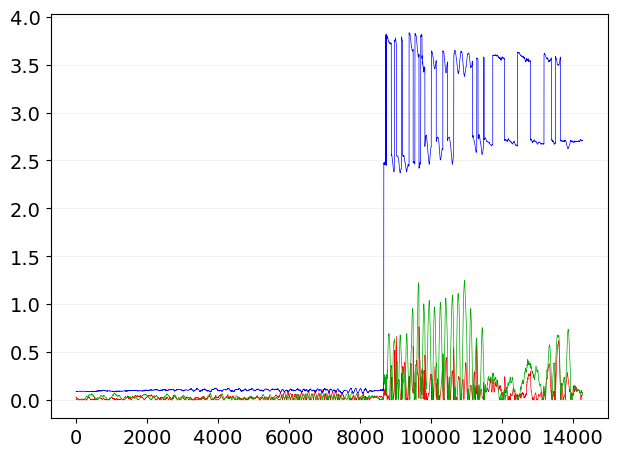

Last distance between sensors and mocap RPY attitude estimations:
[0.07863265 0.05283217 2.70769256]
RMSE of APE between sensors and mocap RPY attitude estimations:
[0.11708854 0.27982594 1.94731601]


Mean distance between sensors and mocap RPY vector g estimations:
[0.0316594  0.02876264 0.00608316]
STD of distance between sensors and mocap RPY vector g estimations:
[0.04594199 0.03957933 0.01144299]
Distance between sensors and mocap RPY vector g estimations:


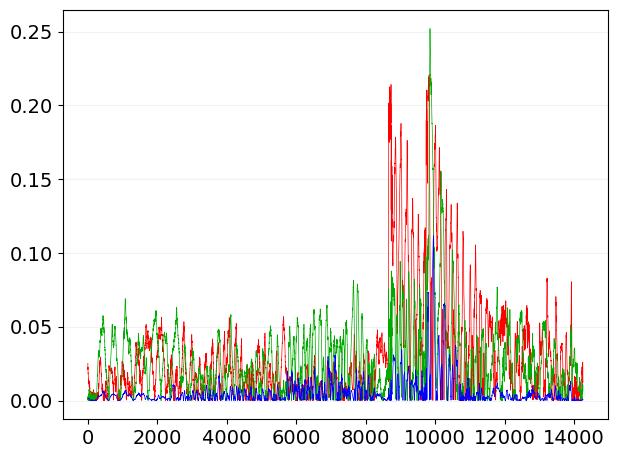

Last distance between sensors and mocap RPY vector g estimations:
[0.01280401 0.01076007 0.00057841]
RMSE of APE between sensors and mocap RPY vector g estimations:
[0.04916001 0.03958845 0.01156495]


Mean Relative Pose Error
Mean distance between sensors and mocap RPY attitude estimations:
[4.60914933 2.03952973 2.10833331]
STD of distance between sensors and mocap RPY attitude estimations:
[74.93127283 18.11782269 21.35908425]
Relative Pose Error RPY


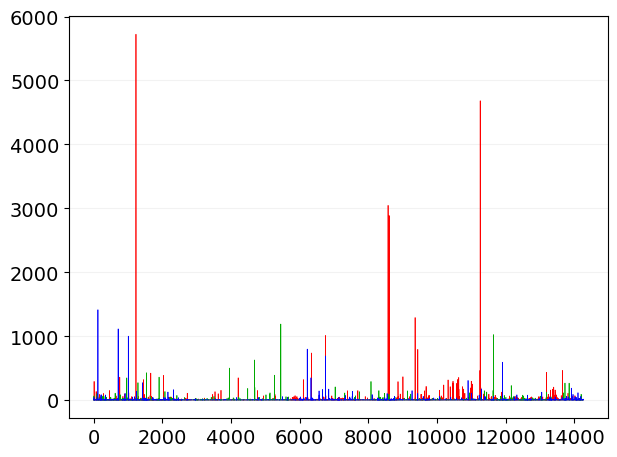

Last RPE between sensors and mocap RPY attitude estimations:
[0. 0. 0.]
RMSE of RPE between sensors and mocap RPY attitude estimations:
[74.92934612 18.12137205 21.37640836]


Mean Relative Pose Error of vector g
Mean distance between sensors and mocap RPY vector g estimations:
[3.16055624 2.44304245 3.11080989]
STD of distance between sensors and mocap RPY vector g estimations:
[52.62297768 26.56520291 59.81629255]
Relative Pose Error RPY of vector g


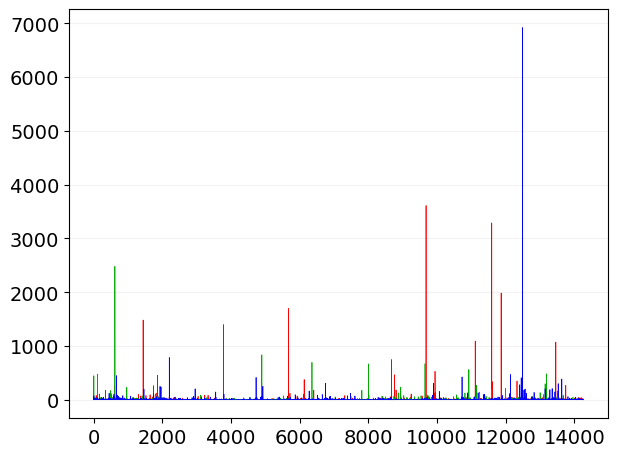

Last RPE between sensors and mocap RPY vector g estimations:
[0. 0. 0.]
RMSE of RPE between sensors and mocap RPY vector g estimations:
[52.64057301 26.58507895 59.81666087]




In [34]:
rpy_sm_aligned = transform.quats_to_rpy(madgwick_result.Q)
rpy_mocap_aligned = transform.quats_to_rpy(data_mocap_q)
(errors["madgwick_rpy_ape_mean"], errors["madgwick_rpy_ape_std"], errors["madgwick_rpy_ape_rmse"],
errors["madgwick_rpy_ape_g_mean"], errors["madgwick_rpy_ape_g_std"], errors["madgwick_rpy_ape_g_rmse"],
errors["madgwick_rpy_rpe_mean"], errors["madgwick_rpy_rpe_std"], errors["madgwick_rpy_rpe_rmse"],
errors["madgwick_rpy_rpe_g_mean"], errors["madgwick_rpy_rpe_g_std"], errors["madgwick_rpy_rpe_g_rmse"]) = compare.errors_estimation_rpy(rpy_sm_aligned, rpy_mocap_aligned, source1="sensors")

# Errors

In [62]:
errors

{'iekf_rpy_ape_mean': array([0.10339858, 0.1570343 , 1.54806329]),
 'iekf_rpy_ape_std': array([0.16117913, 0.27350979, 1.99316718]),
 'iekf_rpy_ape_rmse': array([0.16252303, 0.27398309, 2.00132873]),
 'iekf_rpy_ape_g_mean': array([0.01936411, 0.02655647, 0.00508398]),
 'iekf_rpy_ape_g_std': array([0.02686483, 0.03704096, 0.00832233]),
 'iekf_rpy_ape_g_rmse': array([0.02687562, 0.03742038, 0.00836054]),
 'iekf_rpy_rpe_mean': array([3.88497345, 9.67873513, 5.3948822 ]),
 'iekf_rpy_rpe_std': array([ 39.4260571 , 155.34921171,  95.88701473]),
 'iekf_rpy_rpe_rmse': array([ 39.44033638, 155.37119543,  95.88722176]),
 'iekf_rpy_rpe_g_mean': array([5.32262733, 4.15613969, 5.59463321]),
 'iekf_rpy_rpe_g_std': array([173.21060723,  70.51200764, 154.38122119]),
 'iekf_rpy_rpe_g_rmse': array([173.21038281,  70.53137097, 154.38084428]),
 'iekf_quat_ape_mean': 1.5293345238123401,
 'iekf_quat_ape_std': 1.228524116134872,
 'iekf_quat_ape_rmse': 1.9616395490599305,
 'iekf_quat_ape_g_mean': 0.0372381307

In [70]:
nested_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for composite_key, value in errors.items():
    # Split the key into parts
    parts = composite_key.split('_')
    if len(parts) >= 3:
        model, type_, metric_, metric1 = parts[0], parts[1], parts[2], '_'.join(parts[3:])
        nested_dict[model][type_][metric_][metric1] = value

In [71]:
nested_dict["pf"]

defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
            {'rpy': defaultdict(dict,
                         {'ape': {'mean': 1.5432958626112796,
                           'std': 0.7554161878813267,
                           'rmse': 1.7182478597259239,
                           'g_mean': 0.7098377391224969,
                           'g_std': 0.6617688388735432,
                           'g_rmse': 0.9704519011420253},
                          'rpe': {'mean': 0.009217647424371762,
                           'std': 0.026863053969353137,
                           'rmse': 0.028399613907679144,
                           'g_mean': 0.010269948020552151,
                           'g_std': 0.01693480384721131,
                           'g_rmse': 0.019805032070237698}})})

In [72]:
nested_dict.keys()

dict_keys(['iekf', 'pf', 'madgwick'])

In [74]:
from prettytable import PrettyTable

table1 = PrettyTable()
table2 = PrettyTable()

metric = ["ape", "ape_g", "rpe", "rpe_g"]
type = ["rpy", "quat"]

def make_table(nested_dict, type, metric):
    table = PrettyTable()
    dict = {}
    table.field_names = ["filter", "mean", "std", "rmse", "g_mean", "g_std", "g_rmse"]

    for k in nested_dict.keys():
        table.add_row([
            k,
            nested_dict[k][type][metric]["mean"],
            nested_dict[k][type][metric]["std"],
            nested_dict[k][type][metric]["rmse"],
            nested_dict[k][type][metric]["g_mean"],
            nested_dict[k][type][metric]["g_std"],
            nested_dict[k][type][metric]["g_rmse"]
        ])
    return table

    

print(make_table(nested_dict, "rpy", "ape"))

+----------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+
|  filter  |                mean                |                std                 |                rmse                |               g_mean               |               g_std                |               g_rmse               |
+----------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+
|   iekf   | [0.10339858 0.1570343  1.54806329] | [0.16117913 0.27350979 1.99316718] | [0.16252303 0.27398309 2.00132873] | [0.01936411 0.02655647 0.00508398] | [0.02686483 0.03704096 0.00832233] | [0.02687562 0.03742038 0.00836054] |
|    pf    |         1.5432958626112796         |         0.